In [1]:
# Let's run an example where we observe with ComCam

In [2]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey
from rubin_scheduler.scheduler.utils import SkyAreaGenerator, Footprint, make_rolling_footprints
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleBandSched
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.detailers import BaseDetailer
from rubin_scheduler.utils import _approx_ra_dec2_alt_az, _approx_altaz2pa
import rubin_scheduler.scheduler.basis_functions as bf


from rubin_scheduler.scheduler.surveys import BlobSurvey, GreedySurvey
from rubin_scheduler.scheduler import sim_runner

from rubin_scheduler.site_models import Almanac


import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

In [3]:
# load up a model observatory.
nside=512  # Specify the HEALpix resolution we want to do everything in. Need to turn up for comcam
mjd_start = 60218.
mo = ModelObservatory(nside=nside, mjd_start=mjd_start)

almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

conditions = mo.return_conditions()


In [4]:
# Let's start out with a simple 2-band footprint where we want 1 observations in r for every 2 observations in g
blank_map = np.zeros(hp.nside2npix(nside)) + np.nan
# cut down to a very narrow band
indx = np.where((conditions.dec < np.radians(-15)) & (conditions.dec > np.radians(-20)))
simple_fp = {'r': blank_map + 0, 'g': blank_map + 0}
simple_fp['r'][indx] = 1
simple_fp['g'][indx] = 1

fp = Footprint(mjd_start, sun_ra_start, nside=nside)
for bandname in simple_fp:
    fp.set_footprint(bandname, simple_fp[bandname])

In [5]:
# Let's make two survey objects, one that will observe blobs in r, one in g

# set nside everywhere, and camera="comcam" to both surveys and scheduler!
# Need to set grow_blob to false to avoid a giant loop

footprint_weight = 1.
m5_weight = 0.5

# Specify no detailers so there's no unwanted rotational dithers.
detailers = []

red_fp_basis = bf.FootprintBasisFunction(bandname='r', footprint=fp, nside=nside)
m5_basis_r = bf.M5DiffBasisFunction(bandname='r', nside=nside)
red_survey = BlobSurvey([red_fp_basis, m5_basis_r],
                        [footprint_weight, m5_weight],
                        bandname1='r', survey_name='r_blob', nside=nside,
                        camera="comcam", grow_blob=False, detailers=detailers, 
                        dither="night", twilight_scale=False)

blue_fp_basis = bf.FootprintBasisFunction(bandname='g', footprint=fp, nside=nside)
m5_basis_g = bf.M5DiffBasisFunction(bandname='g', nside=nside)
blue_survey = BlobSurvey([blue_fp_basis, m5_basis_g],
                         [footprint_weight, m5_weight],
                         bandname1='g', survey_name='g_blob', nside=nside,
                         camera="comcam", grow_blob=False, detailers=detailers, dither="night", twilight_scale=False)

scheduler = CoreScheduler([red_survey, blue_survey], nside=nside, camera="comcam")


In [6]:
mo = ModelObservatory(nside=nside, mjd_start=mjd_start)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=3, verbose=True)

progress = 78.55%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 2220 observations
ran in 1 min = 0.0 hours


In [7]:
conditions = mo.return_conditions()
fp_bf = scheduler.survey_lists[0][0].basis_functions[0]

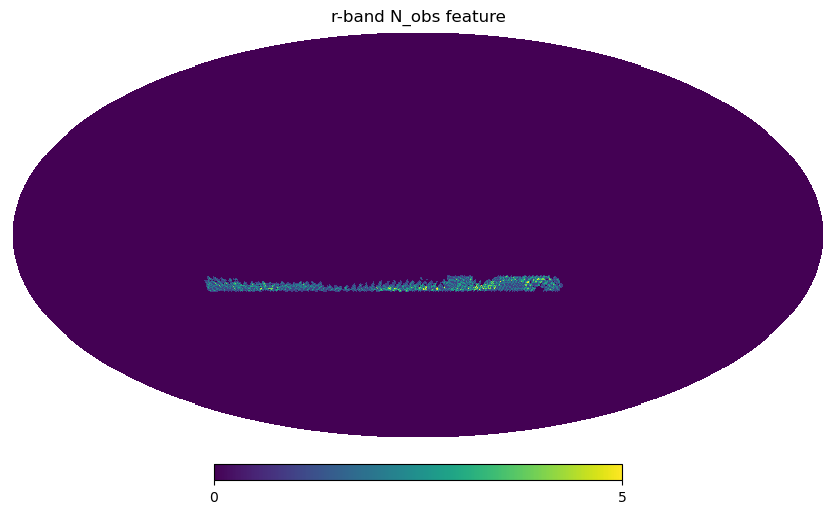

In [8]:
# The basis function holds a dict of Feature objects that track the progress of the survey
hp.mollview(fp_bf.survey_features['N_obs'](), title='r-band N_obs feature')


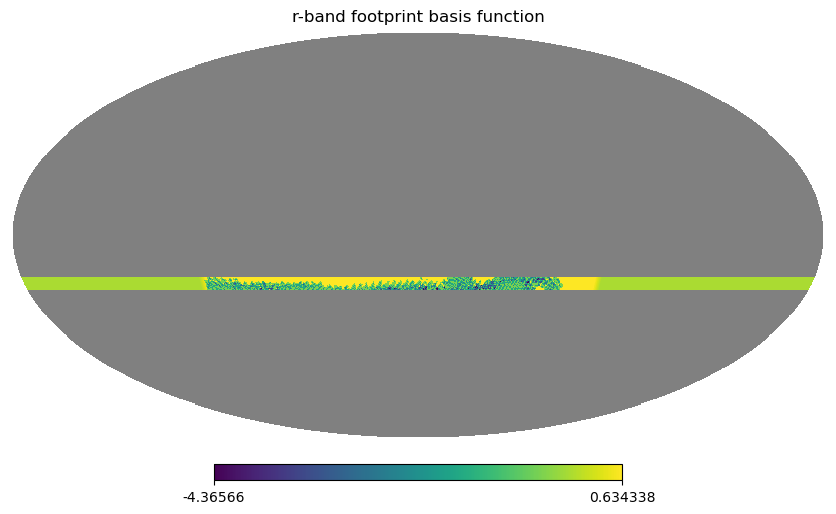

In [9]:
hp.mollview(fp_bf(conditions), title='r-band footprint basis function')

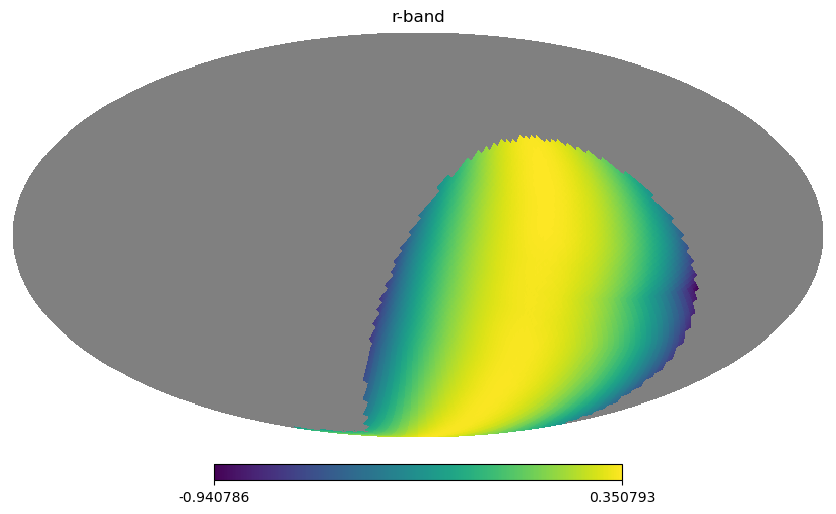

In [10]:
hp.mollview(scheduler.survey_lists[0][0].basis_functions[1](conditions), title='r-band')

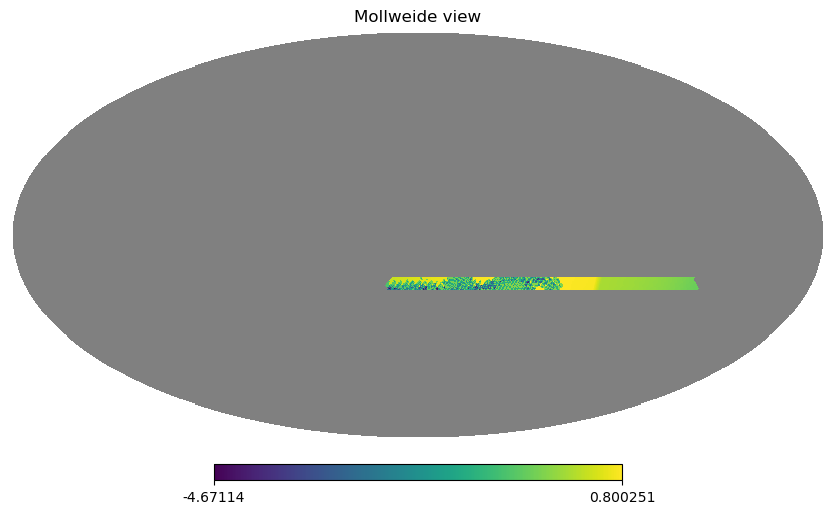

In [11]:
conditions = mo.return_conditions()
rw = scheduler.survey_lists[0][0].calc_reward_function(conditions)
hp.mollview(rw)

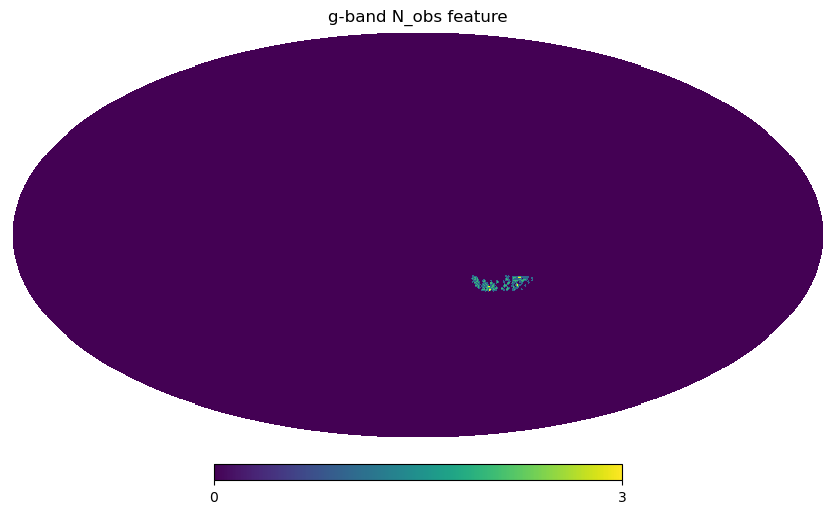

In [12]:
# And now in the g-band
hp.mollview(scheduler.survey_lists[0][1].basis_functions[0].survey_features['N_obs'](),
            title='g-band N_obs feature')

In [13]:
conditions

<Conditions mjd='[60221.00047026]' at 0x3b9feb4d0>

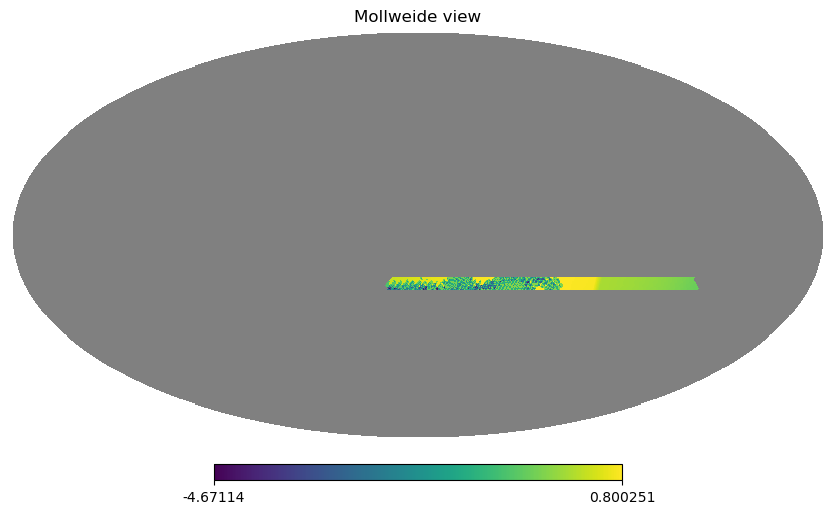

In [14]:
hp.mollview(scheduler.survey_lists[0][0].calc_reward_function(conditions))

Text(0, 0.5, 'dec (deg)')

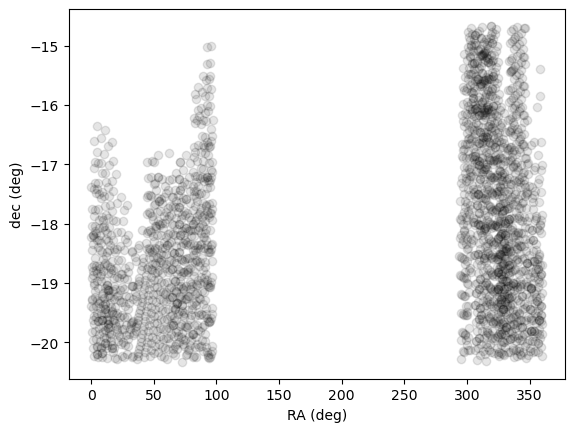

In [15]:
plt.plot(np.degrees(observations["RA"]), np.degrees(observations["dec"]), 'ko', alpha=.1)
plt.xlabel("RA (deg)")
plt.ylabel("dec (deg)")